In [1]:
import matplotlib.pyplot as plt
import torch

Load matrix $Q$

In [ ]:
mat_q = torch.load('mat_q_excluded_missing.pt')

In [ ]:
mat_q_fft = torch.abs(torch.fft.rfft(mat_q, dim=0))
mat_q_fft.shape

torch.Size([16033, 468])

KeyboardInterrupt: 

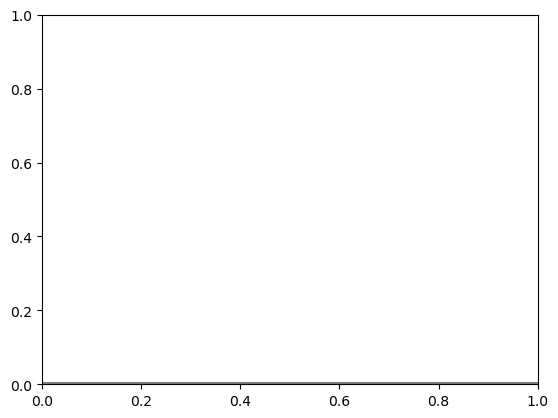

In [ ]:
plt.plot(mat_q_fft)